# Necessary imports. The only tricky one is the holteandtalley pypi package which can be installed using `pip install holteandtalley`

In [1]:
import json
import matplotlib.pyplot as plt
import random
import matplotlib
import numpy as np
import pandas as pd
import pickle
import gsw
from os.path import basename
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# Holte and Talley required 
from holteandtalley import HolteAndTalley
np.random.seed(2)
;

''

# Read oceanographer identifications from pickle file. Make sure identifications.pickle and profiles.json are both in your working directory.

In [2]:
with open("identifications.pickle","rb") as f:
    names = pickle.load(f)

# Extract input data and split it into testing and training data, preserving our testing fraction between high and low latitude data.

In [3]:
def extract_argo_and_split(fname,training_size):
    with open(fname) as f:
        profiles = json.load(f)
        training_size = 0.5
        lowlatprofiles = []
        highlatprofiles = []
        for p in profiles:
            if np.abs(p["lat"])>60:
                highlatprofiles.append(p)
            else:
                lowlatprofiles.append(p)
        chosenlow = np.random.choice(len(lowlatprofiles), size=int(len(lowlatprofiles)*training_size), replace=False)
        chosenhigh = np.random.choice(len(highlatprofiles), size=int(len(highlatprofiles)*training_size), replace=False)
        lowmask = np.zeros_like(lowlatprofiles,bool)
        lowmask[chosenlow] = True
        highmask = np.zeros_like(highlatprofiles,bool)
        highmask[chosenhigh] = True
    return lowlatprofiles+highlatprofiles,np.concatenate((lowmask,highmask))


# Helper functions to generate features from input data and assemble into matrix

In [4]:
def ht_features_reduced(profile):
    d = interpolate.interp1d(profile["pressures"],profile["densities"])
    xnew = np.arange(20, 150, 1)
    densnew = d(xnew)
    date = profile["date"]
    lon = profile["lon"]
    lat = profile["lat"]
    doy = int(date[5:7])*30 + int(date[8:10])
    h = HolteAndTalley(profile["pressures"],profile["temperatures"],profile["salinities"],profile["densities"])
    densfactors = [ h.density.MLTFITDensityPressure, h.density.DThresholdPressure] 
    tempfactors =[h.temp.TTMLDPressure]
    return tempfactors + densfactors

In [5]:
def create_training_data(profiles,chosenprofiles,names,feature_function=ht_features_reduced):
    X = []
    y = []
    for profile in np.asarray(profiles)[chosenprofiles]:
        if profile["name"] in names.keys():
            htp = np.asarray(feature_function(profile))
            if len(names[profile["name"]]["depths"]) >0:
                X.append(np.asarray(htp))
                y.append(np.nanmean(names[profile["name"]]["depths"]))
    return X,y



# Train regression model with a set random state

In [6]:
profiles,chosenprofiles = extract_argo_and_split('profiles.json',0.25)
X,y = create_training_data(profiles,chosenprofiles,names)
y = np.asarray(y)
X = np.asarray(X)
## Random Forest
### REALLY GOOD FOR SOME REASON
regr = RandomForestRegressor(random_state=0, oob_score=True,n_jobs=5)
regr.fit(X,y)


RandomForestRegressor(n_jobs=5, oob_score=True, random_state=0)

# Figure 1.) Mixed Layer identification by oceanographers and algorithms

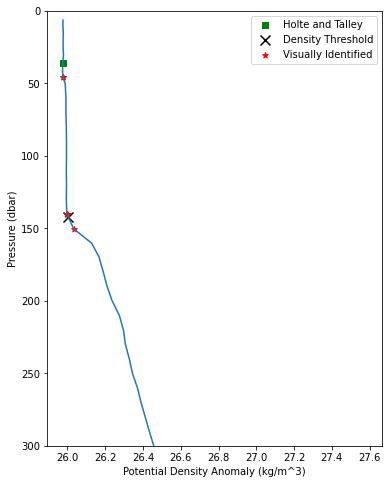

In [7]:
def example_figure(profiles,names,eyed,mlmodel,feature_function):
    X = []
    y = []
    for profile in profiles:
        if eyed in profile["name"]:
            h = HolteAndTalley(profile["pressures"],profile["temperatures"],profile["salinities"],profile["densities"])
            d = interpolate.interp1d(profile["pressures"],profile["densities"])
            X = np.asarray([feature_function(profile)])
            regr_out = np.round(mlmodel.predict(X)[0])
            fig, ax = plt.subplots(figsize=(6,8))
            ax.plot(profile["densities"],profile["pressures"])
            ax.scatter(d(h.densityMLD),h.densityMLD,marker="s",label="Holte and Talley", color= "green")
            ax.scatter(d(h.density.DThresholdPressure),h.density.DThresholdPressure,marker="x",label="Density Threshold", color= "black",s=100)
            depths = np.asarray(names[profile["name"]]["depths"])
            ax.scatter(d(depths),depths,marker="*",label="Visually Identified",c="red")
            ax.legend()
            ax.set_xlabel("Potential Density Anomaly (kg/m^3)")
            ax.set_ylabel("Pressure (dbar)")
            ax.set_ylim(0,300)
            ax.invert_yaxis()

example_figure(profiles,names,"R6902637_097",regr,ht_features_reduced)



# Figure 3.) Boxplot showing ability of algorithms to predict mean visually identified mixed layer depth  

In [8]:
def error_dist_figure(profiles,chosenprofiles,mlmodel,feature_function):
    ht_error = []
    crit_error = []
    regr_error = []
    obs_std = []
    for profile in np.asarray(profiles)[~chosenprofiles]:
        if profile["name"] in names.keys():
            depths=np.asarray(names[profile["name"]]["depths"])
            if len(depths)>0:
                h = HolteAndTalley(profile["pressures"],profile["temperatures"],profile["salinities"],profile["densities"])
                X = np.asarray([feature_function(profile)])
                regr_out = np.round(mlmodel.predict(X)[0])
                regr_error.append((regr_out-np.mean(depths)))
                regr_error[-1] = np.abs(regr_error[-1]/np.mean(depths))
                g = interpolate.interp1d(profile["pressures"],profile["densities"])
                ht_error.append((h.densityMLD-np.mean(depths)))
                ht_error[-1] = np.abs(ht_error[-1]/np.mean(depths))
                obs_std.append(np.std(depths)/np.mean(depths))
                try:
                    #plt.scatter(f(h.temp.TTMLD),h.temp.TTMLD,color="orange")
                    crit_error.append((h.density.DThresholdPressure-np.mean(depths)))
                    crit_error[-1] =np.abs(crit_error[-1]/np.mean(depths))
                except:
                    crit_error.append(np.nan)
                    print("out of range")
    error = np.asarray([regr_error,ht_error,crit_error,obs_std])*100
    plt.close()
    fig, ax = plt.subplots(figsize=(12,15))
    ax.set_ylabel("Percent Of Mean Visually Identified Mixed Layer")
    labels = ["RF Error","H&T (Density) Error","DBM (Density) Error","Obs. STDEV"]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.boxplot(error.T,labels=["RF Error","H&T (Density) Error","Density Thresh Error","Obs. STDEV"])
    plt.title("Comparison of Random Forest Model and Existing Mixed Layer Depth Algorithms")




/home/garrett/micromamba/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


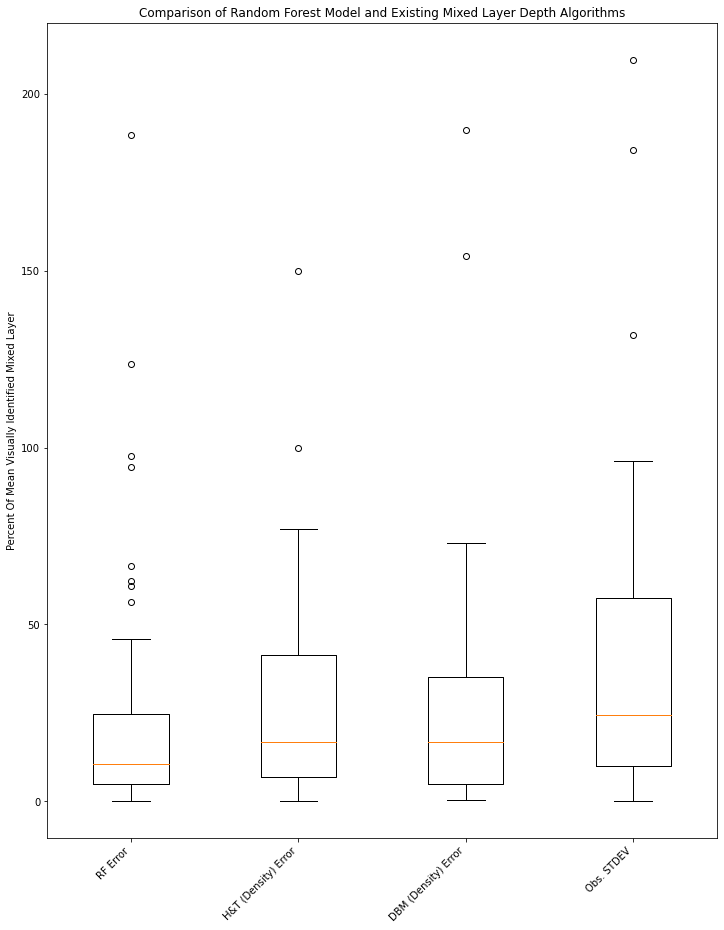

In [9]:
error_dist_figure(profiles,chosenprofiles,regr,ht_features_reduced)


# Figure 2) Standard deviation of oceanographer responses

In [10]:
def obs_std_error(profiles):
    with open('../MLDIdentifierTool/json_generator/profiles.json') as f:
        profiles = json.load(f)
        obs_std=[]
        obs_std_norm=[]
        lats = []
        for profile in np.asarray(profiles)[~chosenprofiles]:
            depths = names[profile["name"]]["depths"]
            depths=np.asarray(depths)
            if len(depths)>0:
                obs_std.append(np.std(depths))
                obs_std_norm.append((np.std(depths)/np.nanmean(depths))*100)
                lats.append(profile["lat"])
        obs_std = np.asarray(obs_std)
        obs_std_norm = np.asarray(obs_std_norm)
        lats = np.asarray(lats)
        plt.close()
        fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(14,8))
        ax1.hist(obs_std,color="black")
        ax1.axvline(x=np.nanmean(obs_std),color='red')
        ax1.axvline(x=np.nanmedian(obs_std),color='blue')
        print(np.median(obs_std))
        ax3.hist(obs_std[np.abs(lats)>50],color="black")
        ax3.axvline(x=np.nanmean(obs_std[np.abs(lats)>50]),color='red')
        ax3.axvline(x=np.nanmedian(obs_std[np.abs(lats)>50]),color='blue')
        ax5.hist(obs_std[np.abs(lats)<50],color="black")
        ax5.axvline(x=np.nanmean(obs_std[np.abs(lats)<50]),color='red')
        ax5.axvline(x=np.nanmedian(obs_std[np.abs(lats)<50]),color='blue')

        ax2.hist(obs_std_norm,color="black")
        ax2.axvline(x=np.nanmean(obs_std_norm),color='red')
        ax2.axvline(x=np.nanmedian(obs_std_norm),color='blue')

        ax4.hist(obs_std_norm[np.abs(lats)>50],color="black")
        ax4.axvline(x=np.nanmean(obs_std_norm[np.abs(lats)>50]),color='red')
        ax4.axvline(x=np.nanmedian(obs_std_norm[np.abs(lats)>50]),color='blue')

        ax6.hist(obs_std_norm[np.abs(lats)<50],color="black")
        ax6.axvline(x=np.nanmean(obs_std_norm[np.abs(lats)<50]),color='red')
        ax6.axvline(x=np.nanmedian(obs_std_norm[np.abs(lats)<50]),color='blue')
        ax6.set_xlabel("Standard Deviation As Perecentage of Mean")
        ax5.set_xlabel("Standard Deviation in Dbar")
        ax1.set_xlim(0,100)
        ax3.set_xlim(0,100)
        ax5.set_xlim(0,100)
        ax2.set_xlim(0,200)
        ax4.set_xlim(0,200)
        ax6.set_xlim(0,200)

15.027013498825292


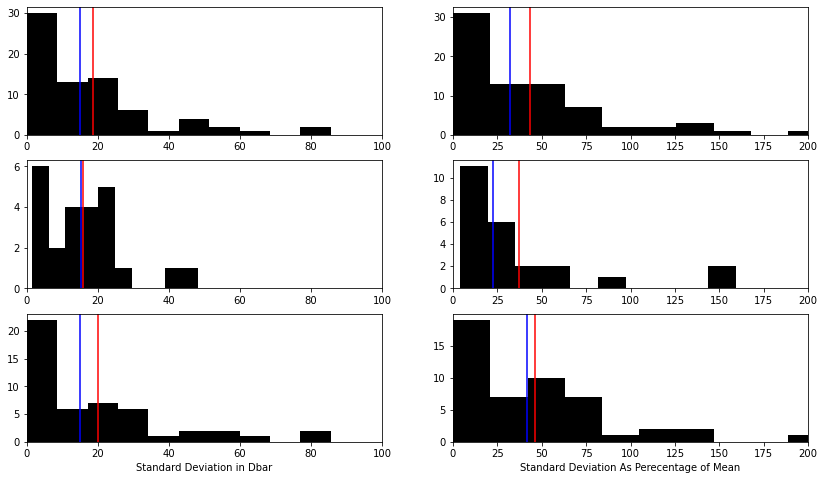

In [11]:
obs_std_error(profiles)

# Figure 4.) Algorithm sensitivity figure (This one can take a long time)

In [12]:

def sensitivity_figure(profiles,names):
    ht_error = []
    regr_error = []
    thresh_error = []
    test_profiles = []
    for profile in np.asarray(profiles)[~chosenprofiles]:
        test_profiles.append(profile)
    plt.close()
    n_iter = 25
    for profile in test_profiles:
        orig_pressures = profile["pressures"]
        orig_salinities = profile["salinities"]
        orig_temperatures = profile["temperatures"]
        orig_densities = profile["densities"]
        ht_results = []
        thresh_results = []
        regr_results = []
        for l in range(n_iter):
            depths = names[profile["name"]]["depths"]
            profile["temperatures"] = np.asarray(orig_temperatures) + np.random.normal(0,0.002*0.5,size=len(orig_temperatures))
            profile["salinities"] = np.asarray(orig_salinities) + np.random.normal(0,0.01*0.5,size=len(orig_salinities))
            profile["densities"] = gsw.sigma0(profile["salinities"],profile["temperatures"])
            h = HolteAndTalley(profile["pressures"],profile["temperatures"],profile["salinities"],profile["densities"])
            X = np.asarray([ht_features_reduced(profile)])
            regr_out = np.round(regr.predict(X)[0])
            ht_results.append(h.densityMLD)
            thresh_results.append(h.density.DThresholdPressure)
            regr_results.append(regr_out)
        ht_error.append(np.std(ht_results))
        regr_error.append(np.std(regr_results))
        thresh_error.append(np.std(thresh_results))
    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))
    ax1.hist(ht_error,range=(0,50),bins=20,color="red",label="Holte and Talley",alpha=0.3)
    ax1.set_ylim(0,60)
    ax2.set_ylim(0,60)
    ax3.set_ylim(0,60)
    ax2.hist(regr_error,range=(0,50),bins=20,color="blue",label = "Random Forest Method",alpha=0.3)
    ax3.hist(thresh_error,range=(0,50),bins=20,color="green", label = "Density Threshold Method",alpha=0.3)



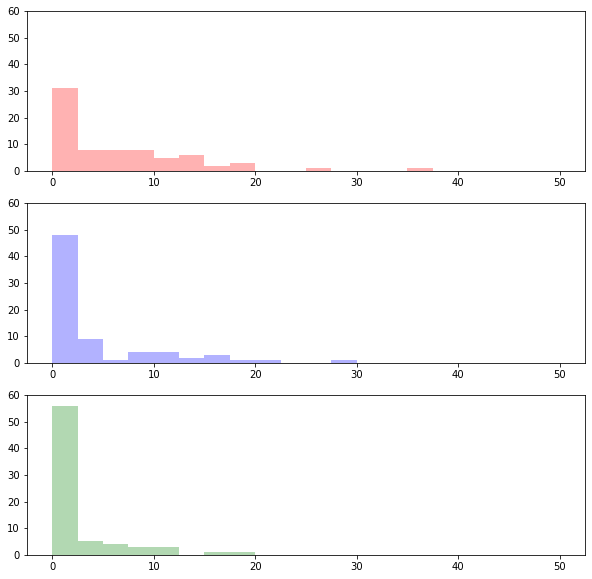

In [13]:
sensitivity_figure(profiles,names)

2.042407542932745 | 0.7542472332656506 1.12583302491977
0.0 | nan nan
33.42551878613777 | 10.801234497346433 13.423393758658799
3.499271061118826 | 0.0 0.0
40.14152740270632 | 0.0 3.569256482341209
8.87323926196065 | 0.8806305718527109 0.0
3.9422998864954106 | 1.3717142559585795 3.0
7.158910531638177 | 0.0 4.763139720814412
0.0 | nan nan
29.67532645144784 | 9.574619226545426 0.5
19.675946156229873 | 4.5 3.6
3.2702786153816037 | 0.0 0.3199999999999989
5.363709071155891 | 3.4081601422990024 2.5834860169933154
16.397603144633333 | 0.5 1.0500000000000007
4.182926607053966 | 3.163331577098215 0.3200000000000017
1.7754840889177235 | 1.5556349186104041 0.8328265125462803
0.9068897284630787 | 0.5629165124598846 0.3299831645537227
10.343597053249901 | 3.3301651610693432 3.6849543944109944
6.018490028422596 | 0.0 3.499271061118826
0.0 | nan nan
17.350724893242578 | 1.9702474463883979 6.2178452859491475
2.753550583578688 | 2.0981473309141596 1.0615436872781088
6.989525691186428 | 4.23342355546902

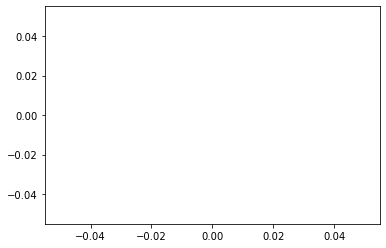

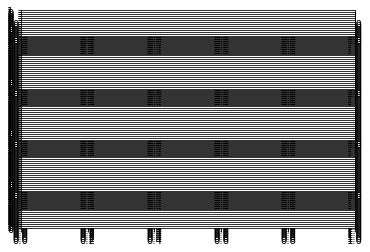

In [60]:
def obs_std_error(profiles):
    with open('../MLDIdentifierTool/json_generator/profiles.json') as f:
        profiles = json.load(f)
        obs_std=[]
        within = []
        obs_std_norm=[]
        lats = []
        for profile in np.asarray(profiles):
            depths = names[profile["name"]]["depths"]
            depths=np.asarray(depths)
            if len(depths)>5:
                m,s = np.mean(depths),np.std(depths)
                print(s,"|",np.std(depths[depths<m]),np.std(depths[depths>m]))
                lats.append(profile["lat"])
                plt.close()
        plt.scatter(obs_std,within)
        fig, ax = plt.subplots(111)
obs_std_error(profiles)

100.34994001263695 10.13007467544427 10.092695372549567


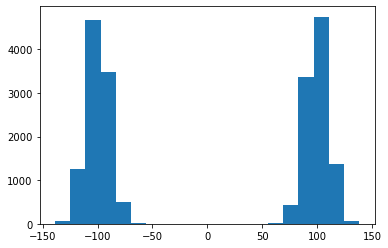

In [61]:
g = np.concatenate((np.random.normal(-100,10,10000),np.random.normal(100,10,10000)))
plt.hist(g,bins=20)
s,m = np.std(g),np.mean(g)
print(s,np.std(g[g<m]),np.std(g[g>m]))